In [1]:
%matplotlib inline

In [2]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# csv
import csv
import gzip

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn import cross_validation
import xgboost as xgb

In [3]:
# get crimes & test csv files as a DataFrame
crimes_df  = pd.read_csv('train.csv')
test_df    = pd.read_csv('test.csv')

# preview the data
crimes_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
crimes_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 no

In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
crimes_df = crimes_df.drop(['Descript','Resolution','Address', 'X', 'Y'], axis=1)
test_df   = test_df.drop(['Address', 'X', 'Y'], axis=1)

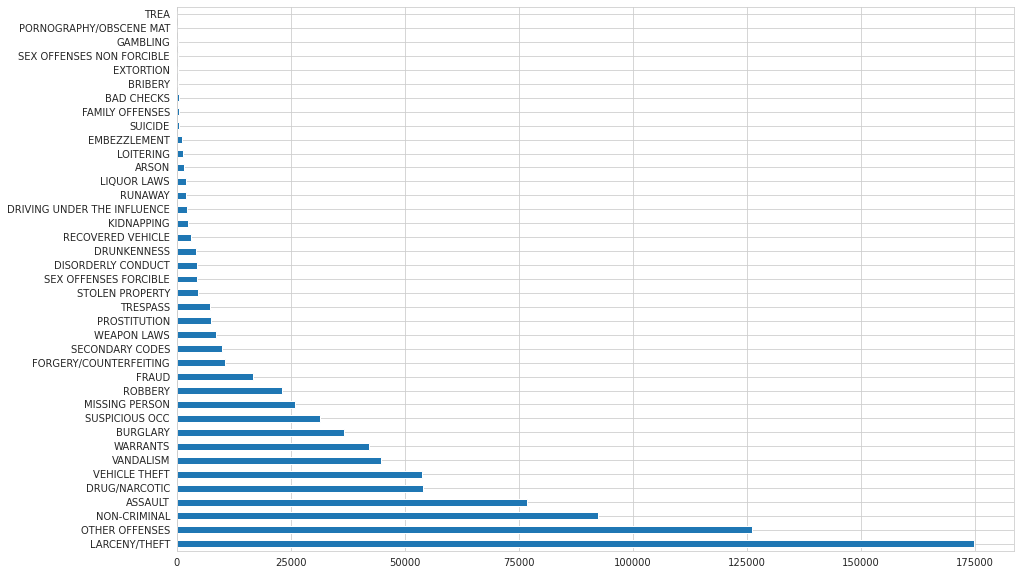

In [6]:
# Category

# Plot
crimes_df["Category"].value_counts().plot(kind='barh', figsize=(15,10))

In [7]:
# Dates

# Convert Date to Year, Month, and Week
crimes_df['Year']  = crimes_df['Dates'].apply(lambda x: int(str(x)[:4]))
crimes_df['Month'] = crimes_df['Dates'].apply(lambda x: int(str(x)[5:7]))

test_df['Year']  = test_df['Dates'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Dates'].apply(lambda x: int(str(x)[5:7]))

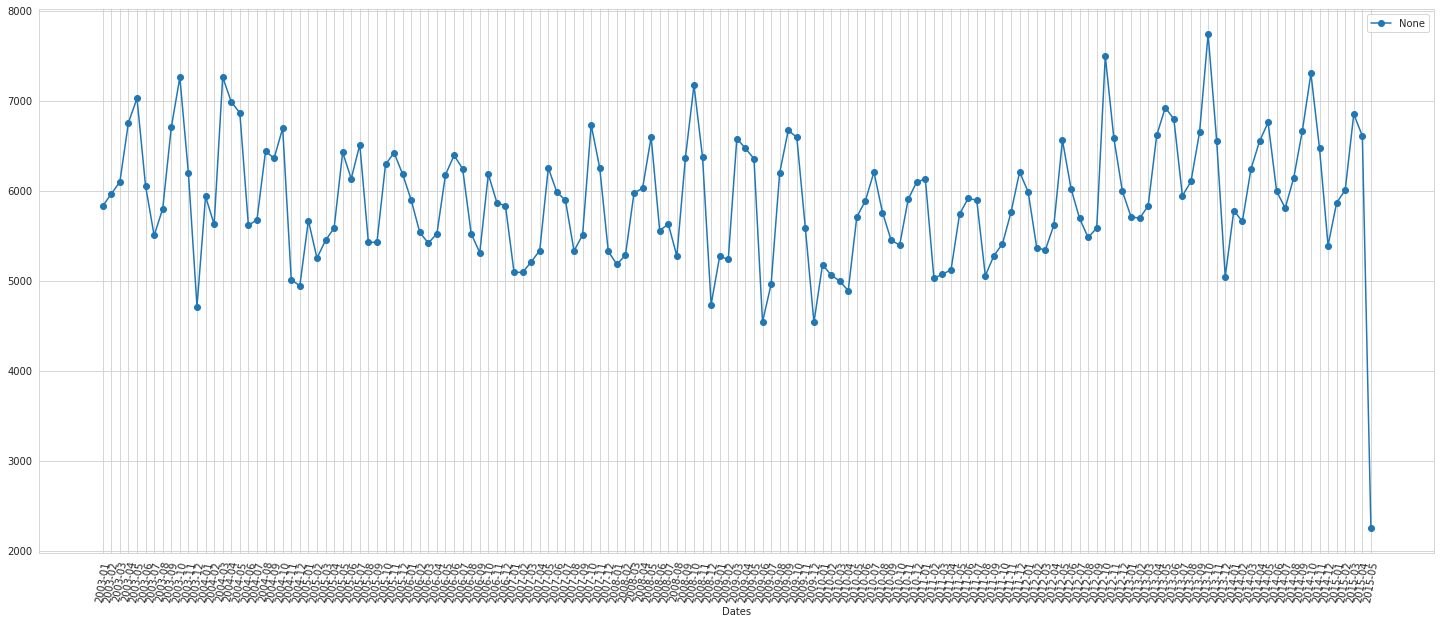

In [8]:
# .... continue with Dates

# Assign Dates column to Dates(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization
crimes_df['Dates'] = crimes_df['Dates'].apply(lambda x: (str(x)[:7]))
test_df['Dates']   = test_df['Dates'].apply(lambda x: (str(x)[:7]))

# count number of crimes by Dates(Year-Month)
count_crimes  = crimes_df.groupby('Dates').size()
# crimes_pct_change  = crimes_df.groupby('Dates').size().pct_change()

fig, (axis1) = plt.subplots(1,1,sharex=True,figsize=(25,10))

# plot number of crimes over time(year-month)
ax1 = count_crimes.plot(legend=True,ax=axis1,marker='o')
ax1.set_xticks(range(len(count_crimes)))
xlabels = ax1.set_xticklabels(count_crimes.index.tolist(), rotation=80)

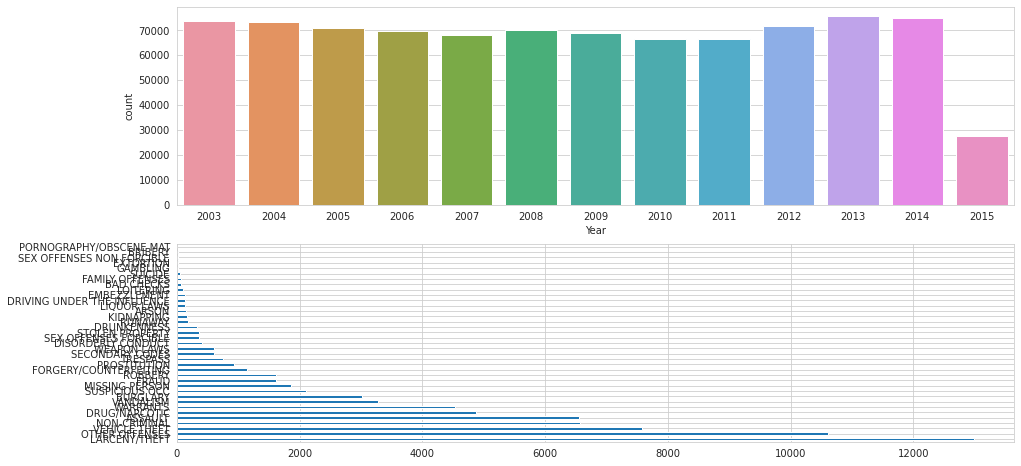

In [9]:
# year
# Which year has higher number of crimes

# Plot
fig, (axis1, axis2) = plt.subplots(2,1,figsize=(15,8))

sns.countplot(x=crimes_df["Year"], ax=axis1)

# most frequent crimes in a year
crimes_df["Category"][crimes_df["Year"] == 2003].value_counts().plot(kind='barh', ax=axis2, ylim=(0,10))

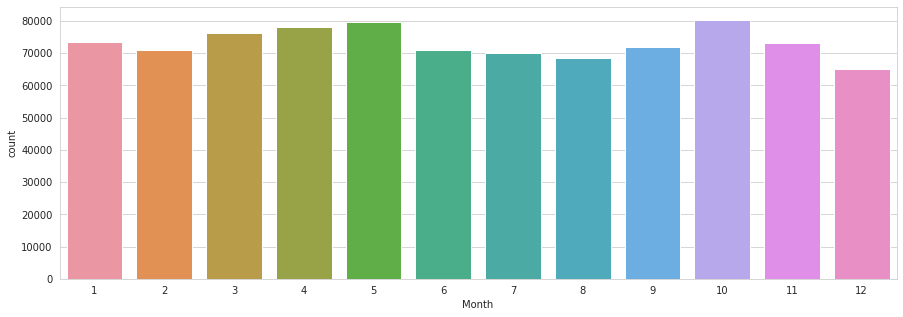

In [10]:
# month
# Which month has higher number of crimes

# Plot
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))

sns.countplot(x=crimes_df["Month"], order=[1,2,3,4,5,6,7,8,9,10,11,12], ax=axis1)

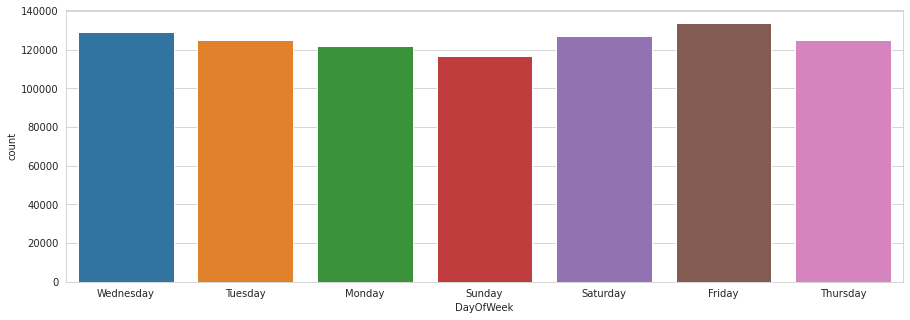

In [11]:
# Create dummy varibales for DayOfWeek
day_dummies_crimes  = pd.get_dummies(crimes_df['DayOfWeek'])
day_dummies_crimes.drop(['Sunday'], axis=1, inplace=True)

day_dummies_test  = pd.get_dummies(test_df['DayOfWeek'])
day_dummies_test.drop(['Sunday'], axis=1, inplace=True)

crimes_df   = crimes_df.join(day_dummies_crimes)
test_df     = test_df.join(day_dummies_test)

# Plot
# Which DayOfWeek has higher number of crimes
fig, (axis1) = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x=crimes_df["DayOfWeek"], ax=axis1)

crimes_df.drop(['DayOfWeek'], axis=1,inplace=True)
test_df.drop(['DayOfWeek'], axis=1,inplace=True)

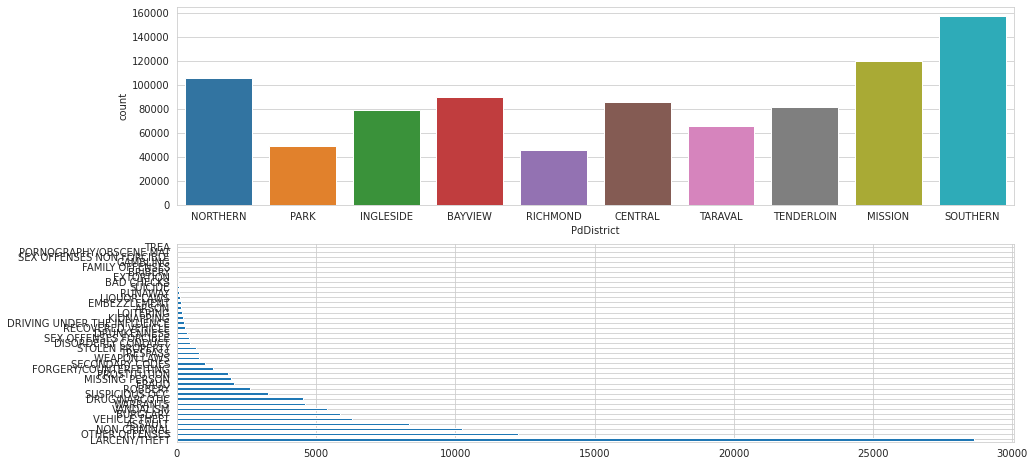

In [12]:
# Create dummy varibales for PdDistrict
day_dummies_crimes  = pd.get_dummies(crimes_df['PdDistrict'])
day_dummies_crimes.drop(['RICHMOND'], axis=1, inplace=True)

day_dummies_test  = pd.get_dummies(test_df['PdDistrict'])
day_dummies_test.drop(['RICHMOND'], axis=1, inplace=True)

crimes_df   = crimes_df.join(day_dummies_crimes)
test_df     = test_df.join(day_dummies_test)

# Plot
# Which PdDistrict has higher number of crimes
fig, (axis1, axis2) = plt.subplots(2,1,figsize=(15,8))
sns.countplot(x=crimes_df["PdDistrict"], ax=axis1)

# most frequent crimes in a PdDistrict
crimes_df["Category"][crimes_df["PdDistrict"] == 'NORTHERN'].value_counts().plot(kind='barh', ax=axis2, ylim=(0,10))

crimes_df.drop(['PdDistrict'], axis=1,inplace=True)
test_df.drop(['PdDistrict'], axis=1,inplace=True)

In [13]:
# drop Dates
crimes_df.drop(['Dates'], axis=1,inplace=True)
test_df.drop(['Dates'], axis=1,inplace=True)

# drop Year and Month
# crimes_df.drop(["Year", "Month"], axis=1, inplace=True)
# test_df.drop(["Year", "Month"], axis=1, inplace=True)

In [14]:
# ordered_crimes   = crimes_df["Category"].value_counts().index.order()
# map_values_dic   = Series(range(0,len(ordered_crimes)), index=ordered_crimes).to_dict()

# crimes_df['Category'] = crimes_df['Category'].map(map_values_dic)

In [15]:
# define training and testing sets

X_train = crimes_df.drop(["Category"],axis=1)
Y_train = crimes_df["Category"].copy()
X_test  = test_df.drop("Id",axis=1).copy()
Y_test  = test_df.drop("Id",axis=1).copy()

In [16]:
print(X_train)
print(Y_train)
print(X_test)

        Year  Month  Friday  Monday  Saturday  Thursday  Tuesday  Wednesday  \
0       2015      5       0       0         0         0        0          1   
1       2015      5       0       0         0         0        0          1   
2       2015      5       0       0         0         0        0          1   
3       2015      5       0       0         0         0        0          1   
4       2015      5       0       0         0         0        0          1   
...      ...    ...     ...     ...       ...       ...      ...        ...   
878044  2003      1       0       1         0         0        0          0   
878045  2003      1       0       1         0         0        0          0   
878046  2003      1       0       1         0         0        0          0   
878047  2003      1       0       1         0         0        0          0   
878048  2003      1       0       1         0         0        0          0   

        BAYVIEW  CENTRAL  INGLESIDE  MISSION  NORTH

#SVM

##一對多法（one-versus-rest，OVR SVMs）

In [17]:
# 因為資料太大，所以先只取100筆來做

from sklearn import svm

clf = svm.SVC(decision_function_shape="ovr")
clf.fit(X_train[:100], Y_train[:100])
y_predict = clf.predict(X_test[:100])

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = clf.predict(X_test[:100])

Accuracy_Score = accuracy_score(Y_train[:100], y_pred[:100])
CM = confusion_matrix(Y_train[:100], y_pred)

print('Average Accuracy: %0.2f +/- (%0.1f) %%' % (Accuracy_Score.mean()*100, Accuracy_Score.std()*100))
print('Confusion Matrix:\n',CM)

Average Accuracy: 45.00 +/- (0.0) %
Confusion Matrix:
 [[ 0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0]]


##一對一法（one-versus-one，OVO SVMs）

In [19]:
# 因為資料太大，所以先只取100筆來做

from sklearn import svm

clf = svm.SVC(decision_function_shape="ovo")
clf.fit(X_train[:100], Y_train[:100])
y_predict = clf.predict(X_test[:100])

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = clf.predict(X_test[:100])

Accuracy_Score = accuracy_score(Y_train[:100], y_pred[:100])
CM = confusion_matrix(Y_train[:100], y_pred)

print('Average Accuracy: %0.2f +/- (%0.1f) %%' % (Accuracy_Score.mean()*100, Accuracy_Score.std()*100))
print('Confusion Matrix:\n',CM)

Average Accuracy: 45.00 +/- (0.0) %
Confusion Matrix:
 [[ 0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0]]


##進行SVC 優化

主要調節的參數有：C、kernel、degree、gamma、coef0，其中：

C: 懲罰係數，越大，趨向於對訓練集全分對的情況，這樣對訓練集測試時準確率很高，但泛化能力弱；C越小，對誤分類的懲罰減小，允許容錯，將他們當成噪聲點，泛化能力較強。

kernel：核函數，默認是rbf，可以是『linear』, 『poly』, 『rbf』, 『sigmoid』, 『precomputed』 

gamma 越大，支持向量越少，gamma 越小，支持向量越多。支持向量的個數影響訓練和預測的速度。

degree: 多項式的次數越高，準確率就越高

In [24]:
# 因為資料太大，所以先只取100筆來做
# 比較不同kernel
from sklearn.metrics import recall_score

def svc(kernel):
  return svm.SVC(kernel=kernel,decision_function_shape="ovo")



def linearsvc():
  return svm.LinearSVC(multi_class="ovr")

def modelist():
  modelist = []
  kernalist = {"linear", "poly", "rbf", "sigmoid"}
  for each in kernalist:
    modelist.append(svc(each))
  modelist.append(linearsvc())
  return modelist

def svc_model(model):
  model.fit(X_train[:100], Y_train[:100])
  acu_train = model.score(X_train[:100], Y_train[:100])
  acu_test = model.score(X_train[:100], Y_train[:100])
  y_pred = model.predict(X_test[:100])
  recall = recall_score(Y_train[:100], y_pred, average="macro")
  return acu_train, acu_test, recall

def run_svc_model(modelist):
  result = {"kernel":[],"acu_train":[],"acu_test":[],"recall":[]}
  for model in modelist:
    acu_train,acu_test,recall = svc_model(model)
    try:
      result["kernel"].append(model.kernel)
    except:
      result["kernel"].append(None)
    result["acu_train"].append(acu_train)
    result["acu_test"].append(acu_test)
    result["recall"].append(recall)

  return pd.DataFrame(result)

run_svc_model(modelist()) # kernel=linear的accuracy跟recall最好

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,kernel,acu_train,acu_test,recall
0,poly,0.45,0.45,0.083333
1,linear,0.50,0.50,0.083191
2,rbf,0.45,0.45,0.083333
3,sigmoid,0.45,0.45,0.083333
4,None,0.34,0.34,0.146866


In [28]:
# 我們發現kernel=linear表現最好，因此以下用linear
def test_c():
  result = {"C":[],"acu_train":[],"acu_test":[],"recall":[]}
  for c in range(1,50,5):
    model = svm.SVC(kernel="linear",C=c,decision_function_shape="ovo")
    acu_train,acu_test,recall = svc_model(model)
    result["C"].append(c)
    result["acu_train"].append(acu_train)
    result["acu_test"].append(acu_test)
    result["recall"].append(recall)

  df = pd.DataFrame(result)
  return df

test_c() # C值不影響

,C,acu_train,acu_test,recall
0,1,0.5,0.5,0.083191
1,6,0.5,0.5,0.083191
2,11,0.5,0.5,0.083191
3,16,0.5,0.5,0.083191
4,21,0.5,0.5,0.083191
5,26,0.5,0.5,0.083191
6,31,0.5,0.5,0.083191
7,36,0.5,0.5,0.083191
8,41,0.5,0.5,0.083191
9,46,0.5,0.5,0.083191


In [26]:
# 我們發現kernel=linear表現最好，因此以下用linear
def test_gamma():
  result = {"gamma":[],"acu_train":[],"acu_test":[],"recall":[]}
  for g in range(1,50,5):
    model = svm.SVC(kernel="linear",gamma=g,decision_function_shape="ovo")
    acu_train,acu_test,recall = svc_model(model)
    result["gamma"].append(g)
    result["acu_train"].append(acu_train)
    result["acu_test"].append(acu_test)
    result["recall"].append(recall)

  df = pd.DataFrame(result)
  return df

test_gamma() # gamma值不影響

,gamma,acu_train,acu_test,recall
0,1,0.5,0.5,0.083191
1,6,0.5,0.5,0.083191
2,11,0.5,0.5,0.083191
3,16,0.5,0.5,0.083191
4,21,0.5,0.5,0.083191
5,26,0.5,0.5,0.083191
6,31,0.5,0.5,0.083191
7,36,0.5,0.5,0.083191
8,41,0.5,0.5,0.083191
9,46,0.5,0.5,0.083191


In [27]:
# 我們發現kernel=linear表現最好，因此以下用linear
def test_degree():
  result = {"degree":[],"acu_train":[],"acu_test":[],"recall":[]}
  for d in range(1,11,1):
    model = svm.SVC(kernel="linear",degree=d,decision_function_shape="ovo")
    acu_train,acu_test,recall = svc_model(model)
    result["degree"].append(d)
    result["acu_train"].append(acu_train)
    result["acu_test"].append(acu_test)
    result["recall"].append(recall)

  df = pd.DataFrame(result)
  return df

test_degree() # degree值不影響

,degree,acu_train,acu_test,recall
0,1,0.5,0.5,0.083191
1,2,0.5,0.5,0.083191
2,3,0.5,0.5,0.083191
3,4,0.5,0.5,0.083191
4,5,0.5,0.5,0.083191
5,6,0.5,0.5,0.083191
6,7,0.5,0.5,0.083191
7,8,0.5,0.5,0.083191
8,9,0.5,0.5,0.083191
9,10,0.5,0.5,0.083191
